# NLP on Food Waste Patent Data

# 1. Data preparation and basic analysis

In [1]:
#Load packages
library(dplyr)
library(tidytext)
library(lubridate)
library(tm)
library(tidyverse)
library(stringr)
library(ggplot2)
library(wordcloud)
library(RColorBrewer)
library(readr)
library(tidyr)
library(igraph)
library(ggraph)
library(widyr)
library(topicmodels)
library(Matrix)
library(janeaustenr)
library(scales)
library(magrittr)
library(Matrix)
library(textstem)
library(DT)
library(tools)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Loading required package: NLP
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v readr   1.1.1
v tibble  1.4.1     v purrr   0.2.4
v tidyr   0.7.2     v stringr 1.2.0
v ggplot2 2.2.1     v forcats 0.2.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x ggplot2::annotate()      masks NLP::annotate()
x lubridate::as.difftime() masks base::as.difftime()
x lubridate::date()        masks base::date()
x dplyr::filter()          masks stats::filter()
x lubridate::intersect()   masks base::intersect()
x dplyr::lag()             masks stats::lag()
x lubridate::setdiff()     masks base::setdiff()
x lubridate::union()       

In [2]:
# Set theme
theme_set(theme_minimal())

In [3]:
#Load data on food waste patents
df <- read.csv("fw1.csv")

In [4]:
# Keep text only
df <- as.character(df$text)

In [5]:
# Clean up text
df <- removeNumbers(df) #remove the numbers from the text
df <- removePunctuation(df) # remove the punctuation

### Tokenize text and remove stop words

In [6]:
# Converting text vector into a dataframe
text_df <- data_frame(line = 1:length(df), text = df)

In [7]:
#Tokenize
tokenized <- text_df %>%
    unnest_tokens(word, text)

In [8]:
#Remove common stop words
data("stop_words")

# Custom stop words
additional_stop_words <- data_frame(word=c("figref", "idrefdrawingsfig", "bb", "xb", "patent", "document", 
                                           "xbsubsub", "fig"， "invention"),
                                   lexicon = rep("custom"))

#Bind stop word data
all_stops <- bind_rows(stop_words, additional_stop_words)

# Remove stops
clean_text_df <- tokenized %>% 
    anti_join(all_stops)

Joining, by = "word"


### Basic word count visualization

In [9]:
# Get count of top words
clean_text_df_count <- clean_text_df %>% 
    count(word, sort = TRUE)  %>% 
    filter(n > 2000)  %>% 
    mutate(word = reorder(word, n)) %>% 
    ggplot(aes(word,n)) +
    geom_col() +
    xlab(NULL) +
    coord_flip()
# clean_text_df_count

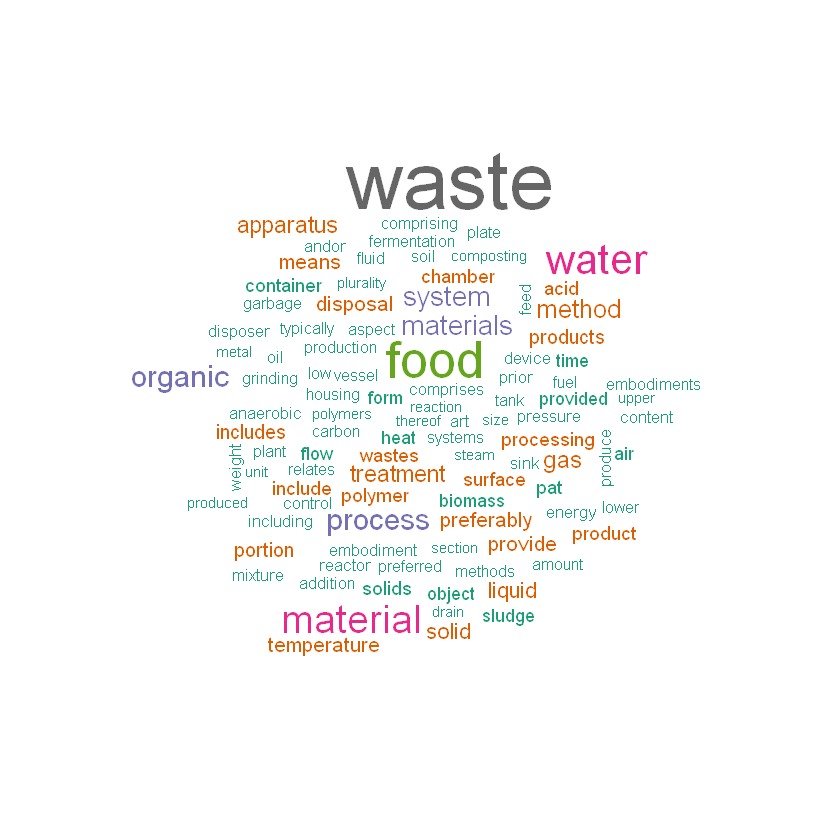

In [10]:
# Show wordcloud of top words
set.seed(0)
clean_text_df %>%
    count(word) %>%
    with(wordcloud(word, n, max.words = 100, colors=brewer.pal(8, "Dark2")))

# 2. TF-IDF

In [11]:
# Import data
df_with_patent_id <- read.csv("fw1.csv", stringsAsFactors = F)

In [12]:
df_with_patent_id$country <- NULL
df_with_patent_id$title <- NULL
df_with_patent_id$abstract <- NULL

In [13]:
df_with_patent_id$Abstract <- df_with_patent_id$text
df_with_patent_id$text <- NULL

In [14]:
df_with_patent_id$Abstract <- as.character(df_with_patent_id$Abstract)  %>% 
    removeNumbers() %>% 
    removePunctuation()

In [15]:
a <- mdy(df_with_patent_id$IssueDate)
df_with_patent_id$IssueDate  <- as.factor(year(a))
# head(df_with_patent_id, n=20)

df_with_patent_id$PatentNo  <- NULL
# df_with_patent_id

In [16]:
abstract_words <- df_with_patent_id %>% 
    unnest_tokens(word, Abstract)  %>% 
    anti_join(all_stops) %>% 
    count(IssueDate, word, sort=TRUE) %>% 
    ungroup()

total_words <- abstract_words %>% 
    group_by(IssueDate) %>% 
    summarize(total = sum(n))

Joining, by = "word"


In [17]:
abstract_words <- left_join(abstract_words, total_words)
# abstract_words

Joining, by = "IssueDate"


Warning message in is.na(e1) | is.na(e2):
"longer object length is not a multiple of shorter object length"Warning message in `==.default`(IssueDate, c("2010", "2011", "2012", "2013", "2014", :
"longer object length is not a multiple of shorter object length"`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 172 rows containing non-finite values (stat_bin)."Warning message:
"Removed 8 rows containing missing values (geom_bar)."

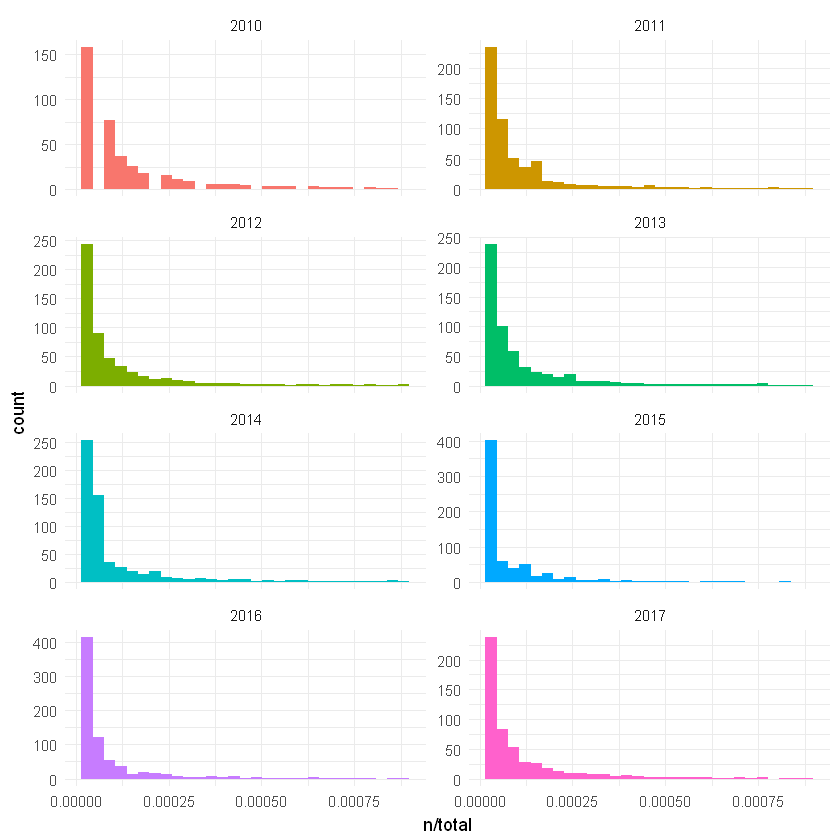

In [18]:
ggplot(subset(abstract_words, IssueDate == c("2010", "2011", "2012", "2013", "2014","2015","2016","2017","2018"), select=c(IssueDate:total)), 
       aes(n/total, fill = IssueDate)) +
  geom_histogram(show.legend = FALSE) +
  xlim(NA, 0.0009) +
  facet_wrap(~IssueDate, ncol = 2, scales = "free_y")

In [19]:
total_words <- df_with_patent_id %>% 
    count(IssueDate, sort=TRUE) 
# total_words

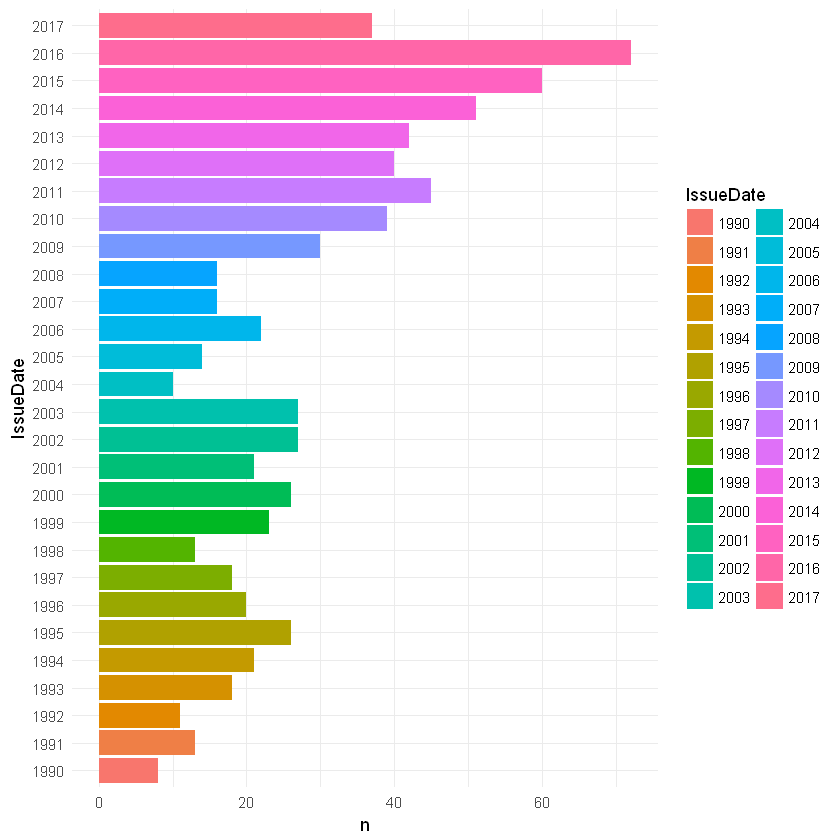

In [20]:
ggplot(data=subset(total_words, IssueDate %in% c("1990":"2018"))) +
    geom_col(aes(IssueDate, n, fill=IssueDate)) +
    coord_flip()

In [21]:
freq_by_rank <- abstract_words %>%
  group_by(IssueDate) %>%
  mutate(rank = row_number(),
         `term frequency` = n/total)

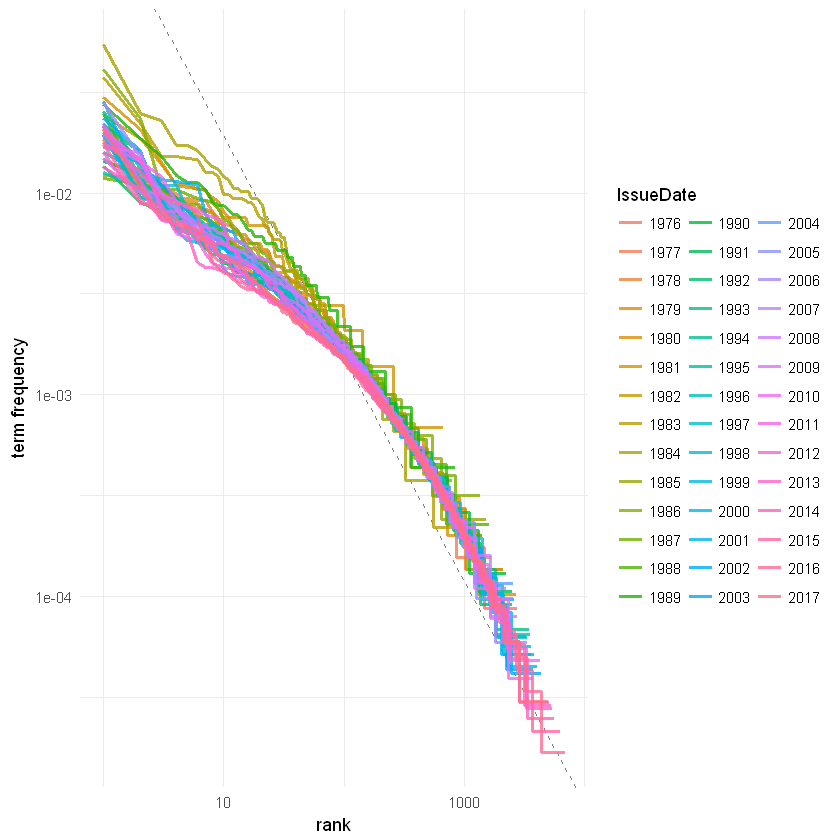

In [22]:
freq_by_rank %>%
  ggplot(aes(rank, `term frequency`, color = IssueDate)) +
  geom_abline(intercept = -0.62, slope = -1.1, color = "gray50", linetype = 2) +
  geom_line(size = 1.1, alpha = 0.8, show.legend = TRUE) +
  scale_x_log10() +
  scale_y_log10()

### TF-IDF on unigrams

In [23]:
abstract_tf_idf <- abstract_words %>% 
  bind_tf_idf(word, IssueDate,n)

In [24]:
abstract_tf_idf %>% 
  select(-total) %>% 
  arrange(desc(tf_idf))

IssueDate,word,n,tf,idf,tf_idf
1981,discs,20,0.013812155,1.9459101,0.02687721
2001,downcomer,133,0.006860621,3.7376696,0.02564273
2007,beak,77,0.006126183,3.7376696,0.02289765
2010,platter,191,0.007463270,3.0445224,0.02272209
1983,finfish,27,0.005909389,3.7376696,0.02208735
1980,restrictor,29,0.005846774,3.7376696,0.02185331
1981,hearth,16,0.011049724,1.9459101,0.02150177
1987,depositor,28,0.005593288,3.7376696,0.02090586
1980,embrittlement,53,0.010685484,1.7917595,0.01914582
2004,asbestos,53,0.006172121,3.0445224,0.01879116


Selecting by tf_idf


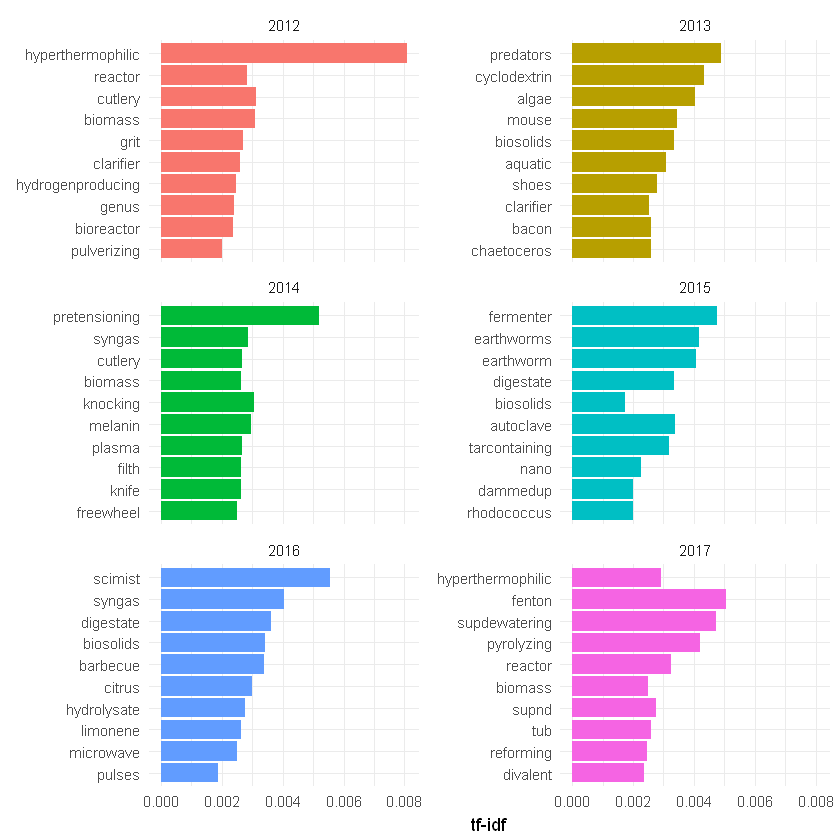

In [25]:
abstract_tf_idf %>% 
  subset(IssueDate %in% c("2012":"2018")) %>% 
  arrange(desc(tf_idf)) %>%
  mutate(word = factor(word, levels = rev(unique(word)))) %>%
  group_by(IssueDate) %>%
  top_n(10) %>%
  ungroup %>%
  ggplot(aes(word, tf_idf, fill = IssueDate)) +
  geom_col(show.legend = FALSE) +
  labs(x = NULL, y = "tf-idf") +
  facet_wrap(~IssueDate, ncol = 2, scales = "free_y") +
  coord_flip()

### TF-IDF on bigrams

In [26]:
abstract_bigrams <- df_with_patent_id %>% 
  unnest_tokens(bigram, Abstract, token = "ngrams", n = 2)

abstract_bigrams %>% 
  count(bigram, sort = TRUE)

bigrams_separated <- abstract_bigrams %>% 
  separate(bigram, c("word1", "word2"), sep = " ")

bigrams_filtered <- bigrams_separated %>%
  filter(!word1 %in% all_stops$word) %>%
  filter(!word2 %in% all_stops$word)

bigram_counts <- bigrams_filtered %>%
  count(word1, word2, sort = TRUE)

bigram,n
of the,22634
in the,9012
to the,7153
from the,4406
the present,4404
and the,4018
present invention,3958
such as,3500
may be,3342
can be,3305


In [27]:
bigrams_Query_filtered <- bigrams_separated %>%
  filter(!word1 %in% all_stops$word) %>%
  filter(!word2 %in% all_stops$word)

bigrams_Query_filtered_counts <- bigrams_Query_filtered %>% 
  count(word1, word2, sort = TRUE)

bigrams_Query_filtered_counts

bigrams_united <- bigrams_Query_filtered %>%
  unite(bigram, word1, word2, sep = " ")

word1,word2,n
food,waste,3107
organic,waste,1105
solid,waste,844
waste,material,699
prior,art,614
waste,disposer,538
waste,disposal,484
organic,material,461
waste,materials,461
anaerobic,digestion,449


In [28]:
bigram_tf_idf <- bigrams_united %>%
  count(IssueDate, bigram) %>%
  bind_tf_idf(bigram, IssueDate, n) %>%
  arrange(desc(tf_idf))
bigram_tf_idf

IssueDate,bigram,n,tf,idf,tf_idf
1984,soil collecting,42,0.037135279,2.639057,0.09800213
1984,collecting circuit,31,0.027409372,2.639057,0.07233490
1984,food soil,34,0.030061892,2.351375,0.07068679
1983,collector body,55,0.026278070,2.639057,0.06934933
1981,pelletized refuse,10,0.018518519,3.737670,0.06921610
1989,float sludge,31,0.031958763,2.128232,0.06801565
1983,soil collecting,50,0.023889154,2.639057,0.06304485
1984,wash chamber,30,0.026525199,2.351375,0.06237070
1984,soil collector,26,0.022988506,2.639057,0.06066798
2001,elongate vessel,131,0.016024465,3.737670,0.05989416


Selecting by tf_idf


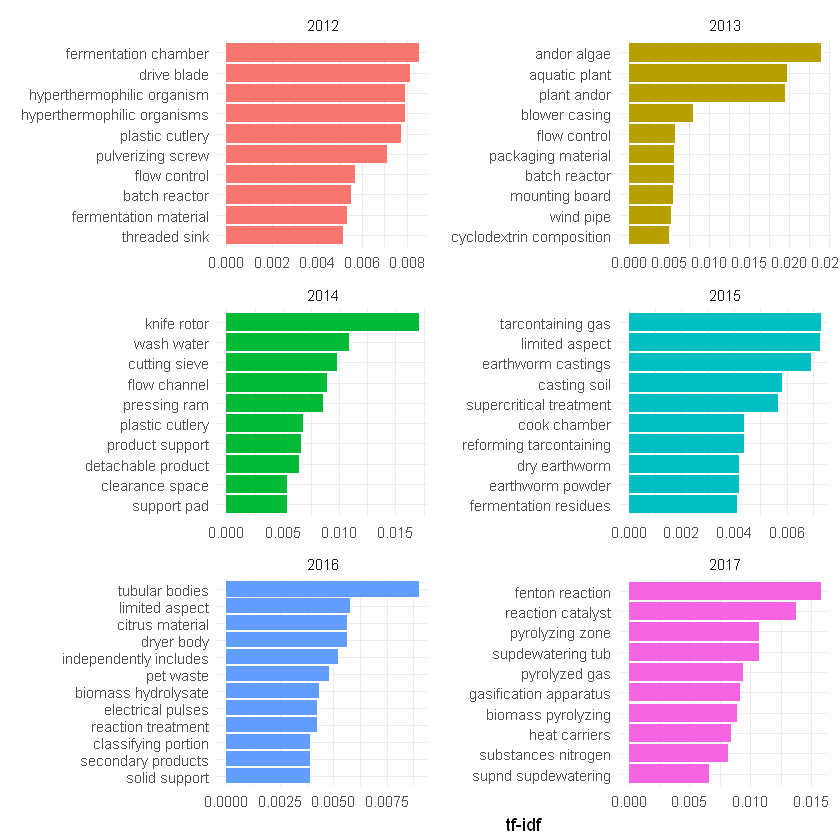

In [29]:
bigram_tf_idf %>%
  subset(IssueDate %in% c("2012":"2018")) %>% 
  arrange(desc(tf_idf)) %>%
  mutate(bigram = factor(bigram, levels = rev(unique(bigram)))) %>%
  group_by(IssueDate) %>%
  top_n(10) %>%
  ungroup %>%
  ggplot(aes(bigram, tf_idf, fill = IssueDate)) +
  geom_col(show.legend = FALSE) +
  labs(x = NULL, y = "tf-idf") +
  facet_wrap(~IssueDate, ncol = 2, scales = "free") +
  coord_flip()

### TF-IDF on trigrams

In [30]:
abstract_trigrams <- df_with_patent_id %>%
  unnest_tokens(trigram, Abstract, token = "ngrams", n = 3)

In [31]:
abstract_trigrams %>%
    count(trigram, sort=TRUE)

trigram,n
the present invention,3937
of the invention,2352
of the present,2040
at least one,1515
us pat no,1318
to provide a,904
portion of the,874
one or more,829
object of the,824
the food waste,788


In [32]:
trigrams_separated <- abstract_trigrams %>% 
    separate(trigram, c("word1","word2","word3", sep = " "))

Warning message:
"Too few values at 1418173 locations: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ..."

In [33]:
trigrams_Query_filtered <- trigrams_separated %>% 
  filter(!word1 %in% all_stops$word) %>% 
  filter(!word2 %in% all_stops$word) %>%
  filter(!word3 %in% all_stops$word)

In [34]:
trigrams_Query_filtered_counts <- trigrams_Query_filtered %>% 
  count(word1, word2, word3, sort = TRUE)

In [35]:
trigrams_united <- trigrams_Query_filtered %>%
  unite(trigram, word1, word2, word3, sep = " ")

In [36]:
trigrams_tf_idf <- trigrams_united %>%
  count(IssueDate, trigram, sort =TRUE) %>%
  bind_tf_idf(trigram, IssueDate, n) %>%
  arrange(desc(tf_idf))

Selecting by tf_idf


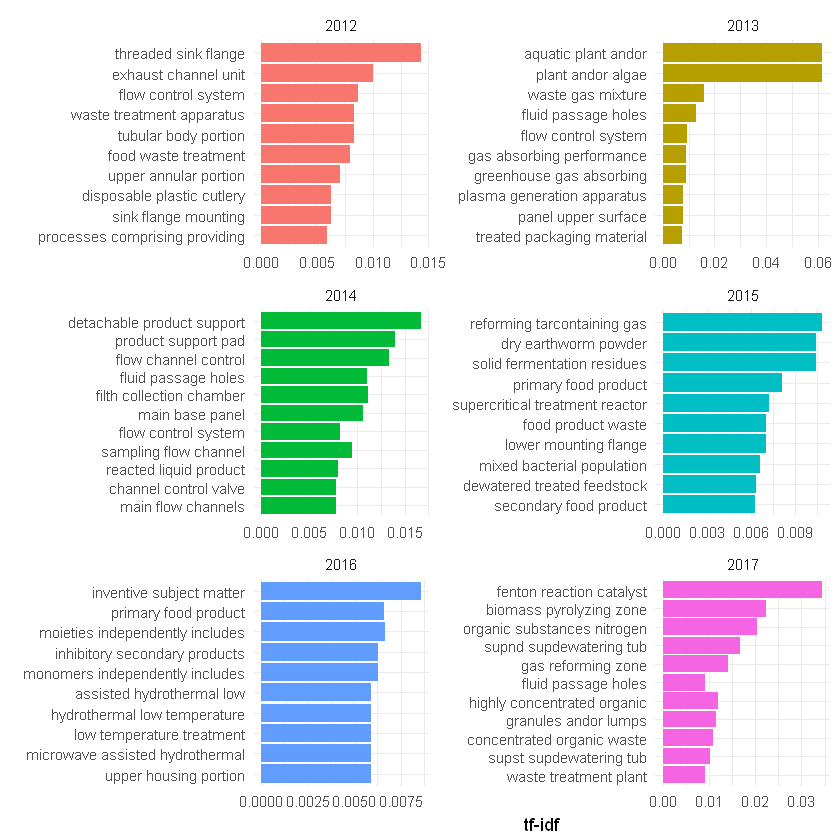

In [37]:
trigrams_tf_idf %>%
  subset(IssueDate %in% c("2012":"2018")) %>% 
  arrange(desc(tf_idf)) %>%
  mutate(trigram = factor(trigram, levels = rev(unique(trigram)))) %>%
  group_by(IssueDate) %>%
  top_n(10) %>%
  ungroup %>%
  ggplot(aes(trigram, tf_idf, fill = IssueDate)) +
  geom_col(show.legend = FALSE) +
  labs(x = NULL, y = "tf-idf") +
  facet_wrap(~IssueDate, ncol = 2, scales = "free") +
  coord_flip()

### Visualizing bigram networks

In [38]:
bigram_graph <- bigrams_Query_filtered_counts %>%
  filter(n > 100) %>%
  graph_from_data_frame()

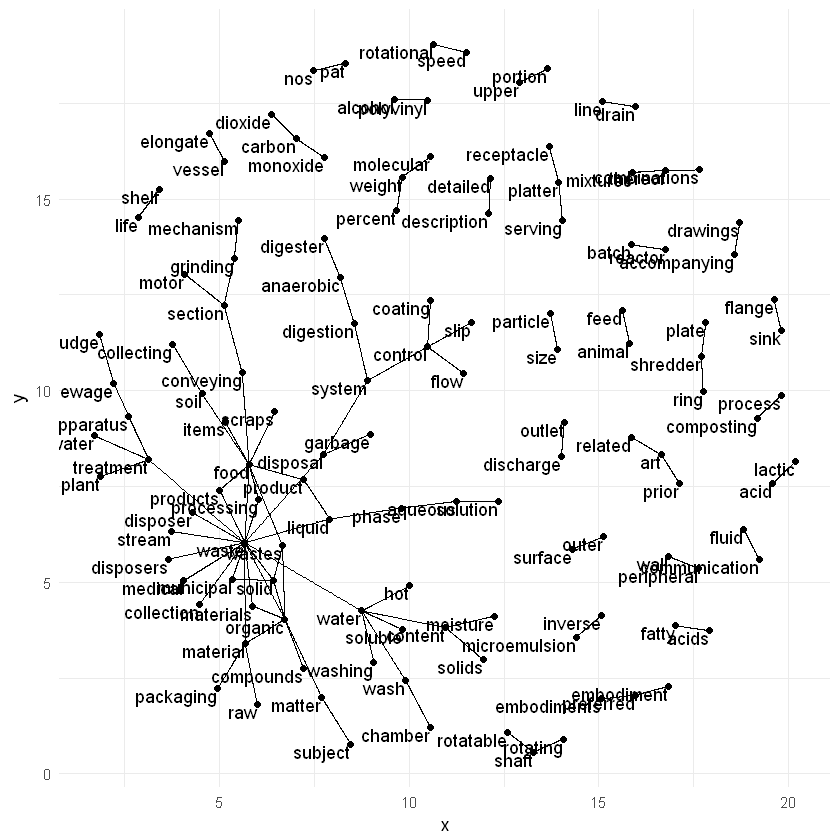

In [39]:
set.seed(2016)

ggraph(bigram_graph, layout = "fr") +
  geom_edge_link() +
  geom_node_point() +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1)

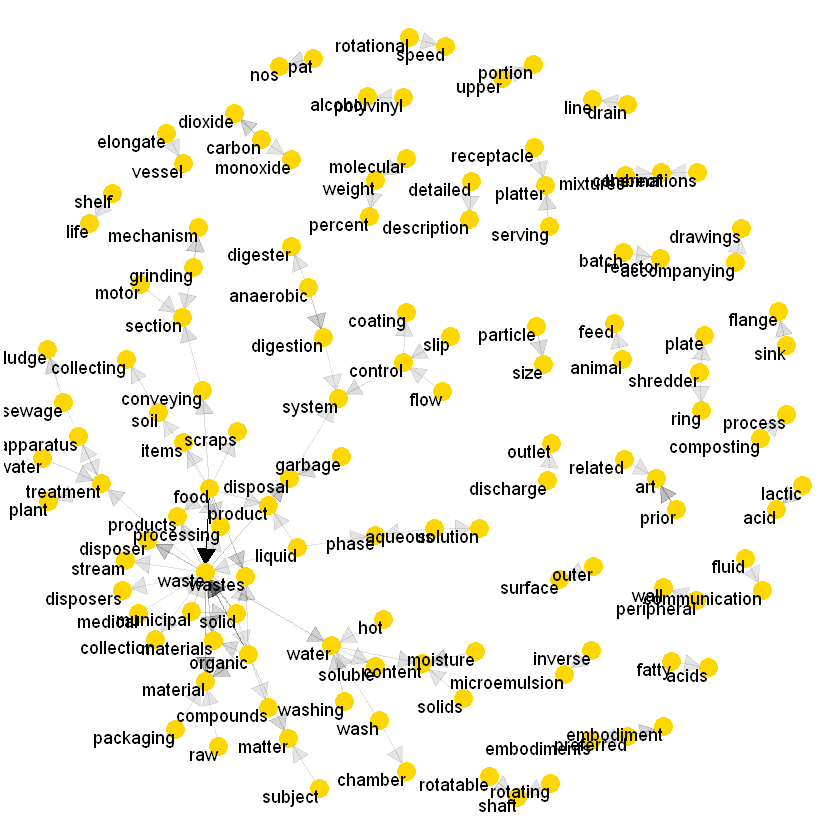

In [40]:
set.seed(2016)
a <- grid::arrow(type = "closed", length = unit(.15, "inches"))
ggraph(bigram_graph, layout = "fr") +
  geom_edge_link(aes(edge_alpha = n), show.legend = FALSE,
                 arrow = a, end_cap = circle(.07, 'inches')) +
  geom_node_point(color = "gold", size = 5) +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1) +
  theme_void()

In [41]:
trigram_graph <- trigrams_Query_filtered_counts %>%
  filter(n > 40) %>%
  graph_from_data_frame()

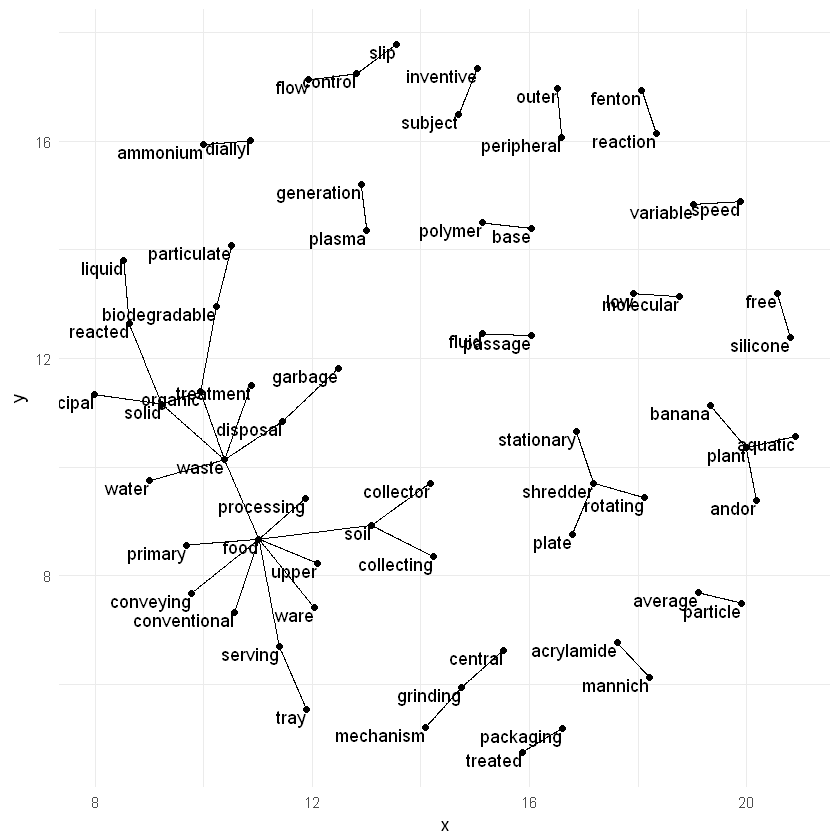

In [42]:
ggraph(trigram_graph, layout = "fr") +
  geom_edge_link() +
  geom_node_point() +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1)

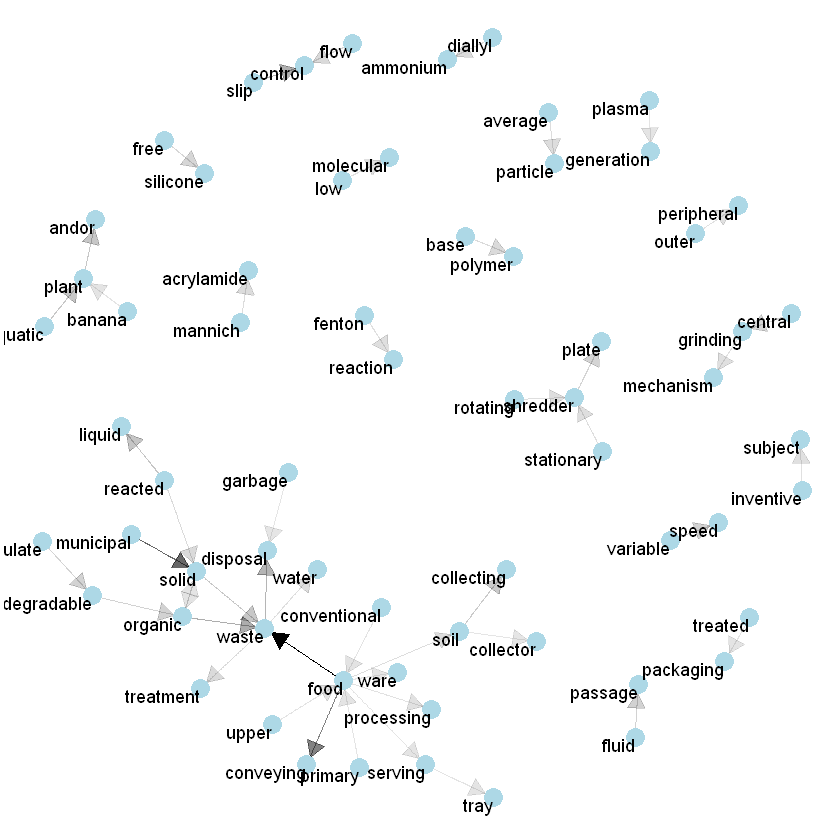

In [43]:
a <- grid::arrow(type = "closed", length = unit(.15, "inches"))
ggraph(trigram_graph, layout = "fr") +
  geom_edge_link(aes(edge_alpha = n), show.legend = FALSE,
                 arrow = a, end_cap = circle(.07, 'inches')) +
  geom_node_point(color = "lightblue", size = 5) +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1) +
  theme_void()

### Word correlations

In [100]:
abstract_section_words <- df_with_patent_id %>%
  filter(IssueDate == "2016") %>%
  mutate(section = row_number() %/%4) %>%
  filter(section > 0) %>%
  unnest_tokens(word, Abstract) %>%
  filter(!word %in% all_stops$word)

In [101]:
word_pairs <- abstract_section_words %>%
  pairwise_count(word, section, sort = TRUE)

In [102]:
word_cors <- abstract_section_words %>%
  group_by(word) %>%
  filter(n() >= 50) %>%
  pairwise_cor(word, section, sort = TRUE)
word_cors

item1,item2,correlation
limonene,citrus,1
citrus,limonene,1
process,methods,1
processes,methods,1
liquid,methods,1
time,include,1
reference,include,1
capable,include,1
application,processing,1
include,time,1


Selecting by correlation
ERROR while rich displaying an object: Error: Faceting variables must have at least one value

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste(capture.output(print(obj)), collapse = "\n")
10. capture.output(print(obj))
11. evalVis(expr)
12. withVisible(eval(expr, pf))
13. eval(expr, pf)
14. eval(expr, pf)
15. print(obj)
16. print.ggplot(obj)
17. ggplot_build(x)
18. layou

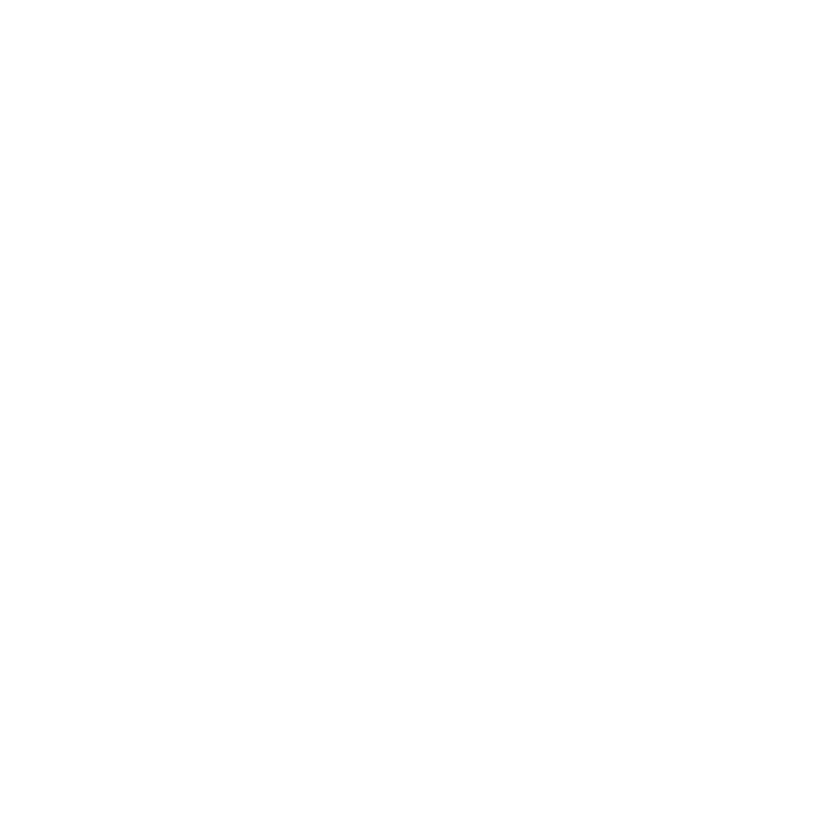

In [103]:
word_cors %>%
  filter(item1 %in% c("food", "waste")) %>%
  group_by(item1) %>%
  top_n(7) %>%
  ungroup() %>%
  mutate(item2 = reorder(item2, correlation)) %>%
  ggplot(aes(item2, correlation)) +
  geom_bar(stat = "identity") +
  facet_wrap(~ item1, scales = "free_x") +
  coord_flip()

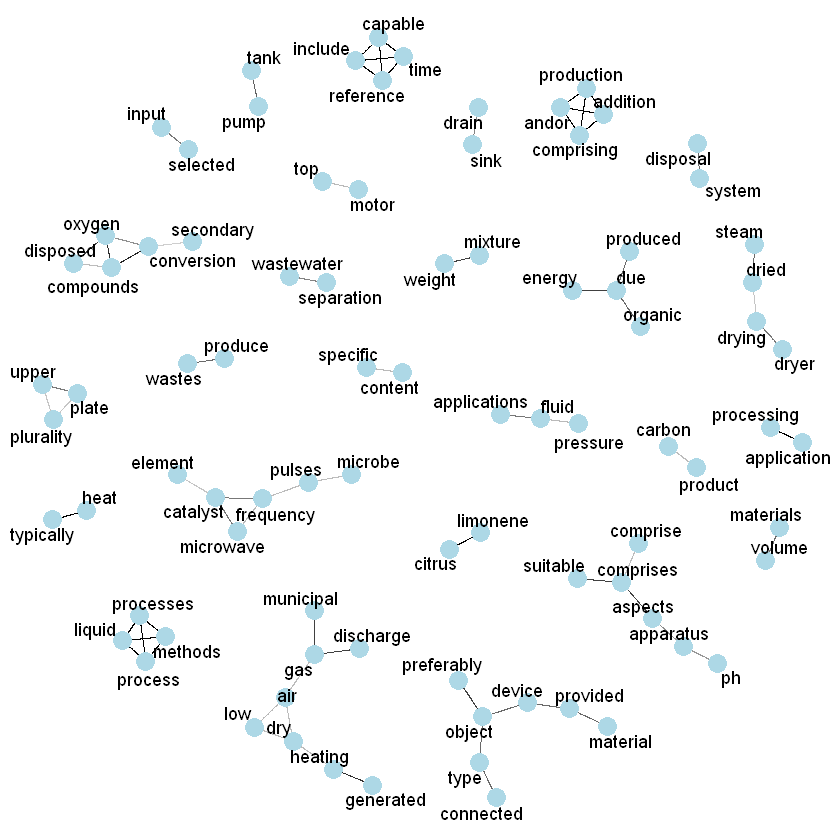

In [104]:
word_cors %>%
  filter(correlation > .70) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(edge_alpha = correlation), show.legend = FALSE) +
  geom_node_point(color = "lightblue", size = 5) +
  geom_node_text(aes(label = name), repel = TRUE) +
  theme_void()

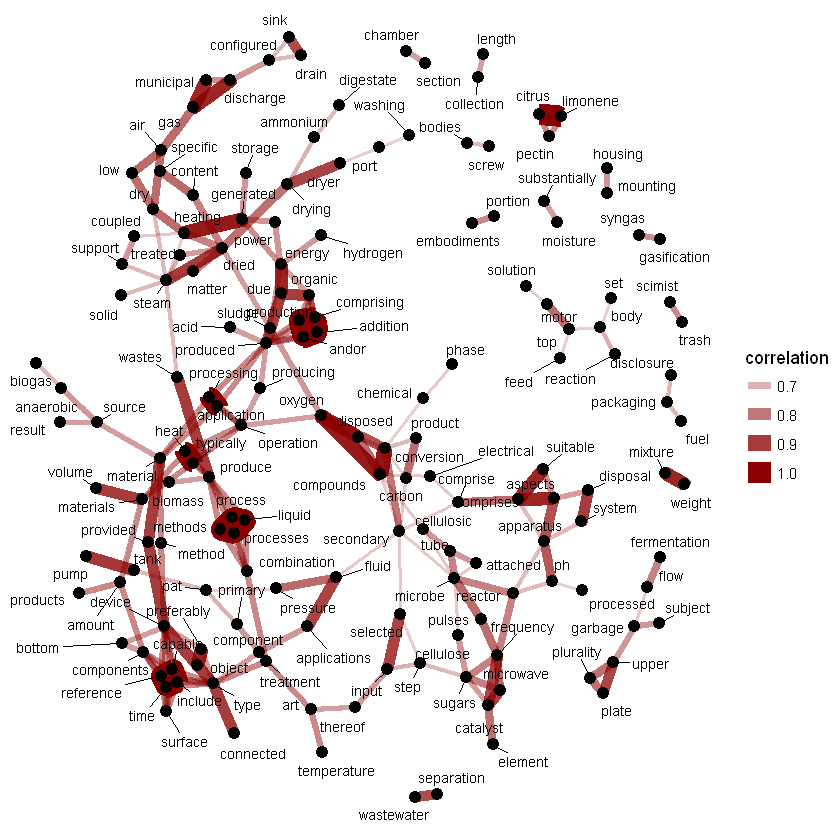

In [109]:
set.seed(1)
word_cors %>%
  filter(correlation > .60) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(edge_alpha = correlation, edge_width = correlation),
                 edge_colour = 'darkred',
                 show.legend = TRUE) +
  geom_node_point(size = 3) +
  geom_node_text(aes(label = name), repel = TRUE, size=3,
                 point.padding = unit(0.2, "lines")) +
  theme_void()

### Latent dirichlet analysis

In [29]:
#Load data
filename = "fw1.csv" # "fw1.csv" is our raw data which has been slightly pre-processed in Excel. 
df <- read.csv(filename)
df$text <- as.character(df$text)
df$IssueDate <- as.factor(df$IssueDate)

In [30]:
str(df)

'data.frame':	866 obs. of  6 variables:
 $ PatentNo : Factor w/ 866 levels "3930799","3937977",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ title    : Factor w/ 760 levels "<i>Sphingomonas </i>sp. microorganism and method for decomposing methane or odor-producing compounds using the same",..: 41 115 73 620 356 565 400 139 547 694 ...
 $ abstract : Factor w/ 785 levels ""," A bag opener for opening bags containing recyclable materials includes a source of heat sufficient to melt the"| __truncated__,..: 219 177 196 246 225 237 67 278 110 239 ...
 $ text     : chr  "This invention relates to apparatus for making organic fertilizer, sometimes referred to as compost or humus, f"| __truncated__ "1. Field of the Invention This invention relates to an improvement in electrical circuitry employed to connect "| __truncated__ "Various methods and apparatus for cleaning and sorting culinary items have been proposed heretofore. See for ex"| __truncated__ "The present invention relates to the handling of soiled 

In [31]:
#Remove common stop words
data("stop_words")

# Custom stop words
additional_stop_words <- data_frame(word=c("figref", "idrefdrawingsfig", "bb", "xb", "patent", "document", 
                                           "xbsubsub", "fig"， "invention"),
                                   lexicon = rep("custom"))

#Bind stop word data
all_stops <- bind_rows(stop_words, additional_stop_words)

In [32]:
#Define a function to clean our text
#Here we lemmatize words and remove punctiation, numbers, and stopwords. 
clean_patent <- function(df, column_name){
    #clean the text of a patent : put to lowercase, lemmatize, remove punctuation and numbers
    start.time <- Sys.time()
    cleaned_text <- df[,c(column_name)]%>%
        tolower() %>%
        lemmatize_strings() %>%
        removeWords(all_stops$word) %>%
        removeNumbers() %>%
        removePunctuation()
    end.time <- Sys.time()
    time.taken <- end.time - start.time
    time.taken
    return(cleaned_text)  
}

In [33]:
df[,c("text")] <- clean_patent(df, "text")

In [34]:
#Define function to create a document-term matrix
create_document_matrix <- function(df){
    #create document matrix
    text_lda <- df %>%
        mutate(PatentNo = as.integer(PatentNo)) %>%
        as_tibble() %>%
        select_("text","PatentNo") %>% 
        unnest_tokens(word, text) %>%
        count(PatentNo, word) %>% 
        cast_dtm(PatentNo, word, n)
    text_lda
}

In [35]:
#Split the data between train and validation set : the validation set will be used to get the right number of topics
n <- nrow(df)
splitter <- sample(1:n, round(n * 0.7))
train_set <- df[splitter, ]
valid_set <- df[-splitter, ]

In [36]:
str(train_set)

'data.frame':	606 obs. of  6 variables:
 $ PatentNo : Factor w/ 866 levels "3930799","3937977",..: 230 550 861 352 675 525 824 734 549 201 ...
 $ title    : Factor w/ 760 levels "<i>Sphingomonas </i>sp. microorganism and method for decomposing methane or odor-producing compounds using the same",..: 465 474 518 517 157 635 748 653 629 509 ...
 $ abstract : Factor w/ 785 levels ""," A bag opener for opening bags containing recyclable materials includes a source of heat sufficient to melt the"| __truncated__,..: 262 646 451 515 678 606 600 626 340 94 ...
 $ text     : chr  "field     relate    apparatus  method  compact  pulverize waste  soil   specifically   mobile compactor  pulver"| __truncated__ "background     relate  compost device compost   purposeful biodegradation  organic matter   yard  food waste  y"| __truncated__ " technical field       refer   poultry feeder specifically refer   feeder   bird  initial stage   growth  poult"| __truncated__ "background    food waste disposer  

In [37]:
#Make a document term matrix for the training set and the validation set
lda_document_matrix_train <- create_document_matrix(train_set)
lda_document_matrix_valid <- create_document_matrix(valid_set)

In [39]:
#Function to create LDA model based on different topics
create_lda_model <- function(document_matrix, num_topics, seed=1234){
    #create lda model
    lda_model <- LDA(document_matrix, k=num_topics, control = list(seed=seed))
    lda_model
}

In [40]:
# Let's try out different values of K. CAREFUL, this takes a few hours to run. 
candidate_k <- c(2, 4, 8, 10, 20, 30) 
perplexities <- vector(mode="list", length=length(candidate_k))
names(perplexities) <- candidate_k
index <- 1
start.time <- Sys.time()
for(k in candidate_k){
    print(paste("k=",k,sep=""))
    lda_model <- create_lda_model(lda_document_matrix_train, k)
    perplexities[index] <- perplexity(lda_model, newdata = lda_document_matrix_valid)
    index <- index + 1
}
end.time <- Sys.time()
print(end.time - start.time)
print(perplexities)

[1] "k=2"
[1] "k=4"
[1] "k=8"
[1] "k=10"
[1] "k=20"
[1] "k=30"
Time difference of 25.03346 mins
$`2`
[1] 1435.125

$`4`
[1] 1313.937

$`8`
[1] 1148.934

$`10`
[1] 1121.004

$`20`
[1] 984.6929

$`30`
[1] 930.5961



In [41]:
save(perplexities, file = "perplexities.rda")
#load("perplexities.rda")

In [42]:
Topics <- candidate_k
Perplexity <- c(perplexities[[1]],perplexities[[2]],perplexities[[3]],perplexities[[4]],perplexities[[5]],perplexities[[6]])

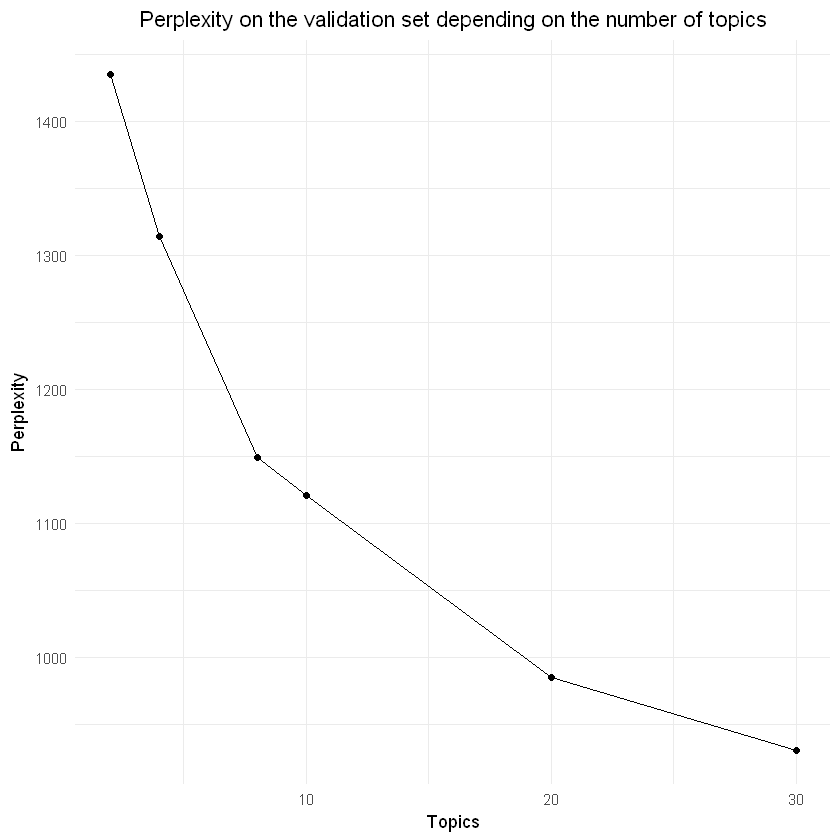

In [43]:
num_topics_vs_perplexity <- data.frame(Topics, Perplexity)
ggplot(num_topics_vs_perplexity, aes(Topics, Perplexity)) + 
    geom_line() + 
    geom_point() + 
    ggtitle("Perplexity on the validation set depending on the number of topics") +
    theme(plot.title = element_text(hjust = 0.5))

In [44]:
lda_df <- as_tibble(text_df)

In [53]:
abstract_lda <- lda_df %>% 
  unnest_tokens(word, text) %>% 
  anti_join(all_stops) %>% 
  count(line, word) %>% 
  cast_dtm(line, word, n)

Joining, by = "word"


In [54]:
abstract_lda

<<DocumentTermMatrix (documents: 866, terms: 24684)>>
Non-/sparse entries: 273082/21103262
Sparsity           : 99%
Maximal term length: 58
Weighting          : term frequency (tf)

In [55]:
ap_lda <- LDA(abstract_lda, k=20, control = list(seed=1234))

In [56]:
ap_topics <- tidy(ap_lda, matrix = "beta")
ap_topics

topic,term,beta
1,accept,3.904112e-44
2,accept,5.281286e-05
3,accept,7.057033e-05
4,accept,2.639751e-70
5,accept,2.975061e-05
6,accept,5.322148e-04
7,accept,6.656161e-16
8,accept,3.648177e-05
9,accept,1.436543e-05
10,accept,4.114650e-20


In [70]:
ap_top_terms <- ap_topics %>%
  group_by(topic) %>%
  top_n(10, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

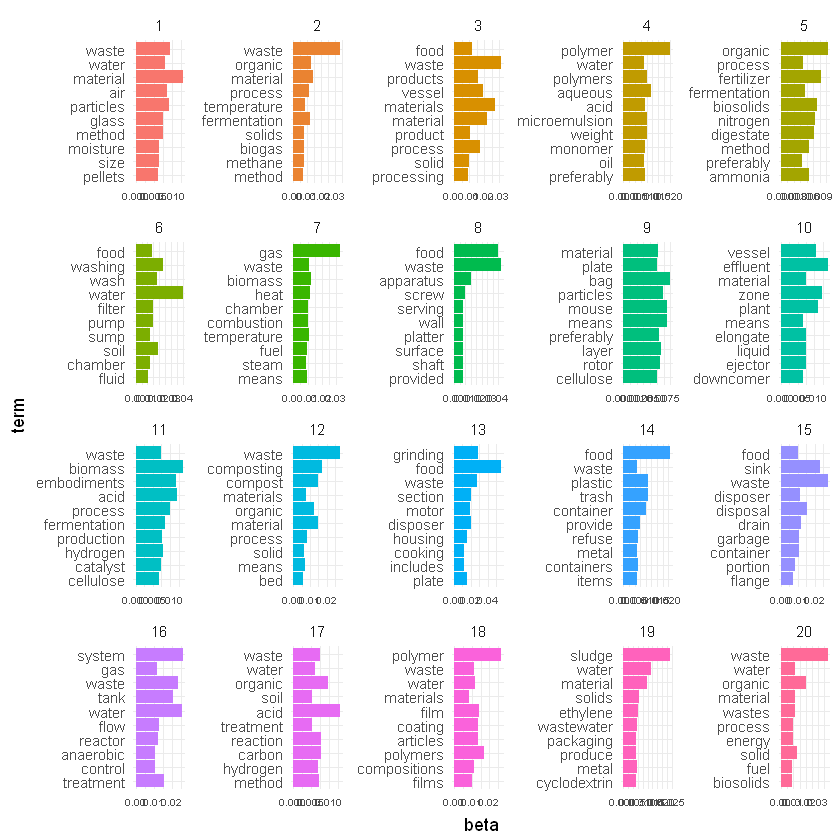

In [71]:
ap_top_terms %>%
  mutate(term = reorder(term, beta)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip() +
  theme(axis.text.x=element_text(size=rel(0.7)))

In [59]:
#beta spread topics 1 and 2
beta_spread <- ap_topics %>%
  mutate(topic = paste0("topic", topic)) %>%
  spread(topic, beta) %>%
  filter(topic1 > .001 | topic2 > .001) %>%
  mutate(log_ratio = log2(topic2 / topic1))

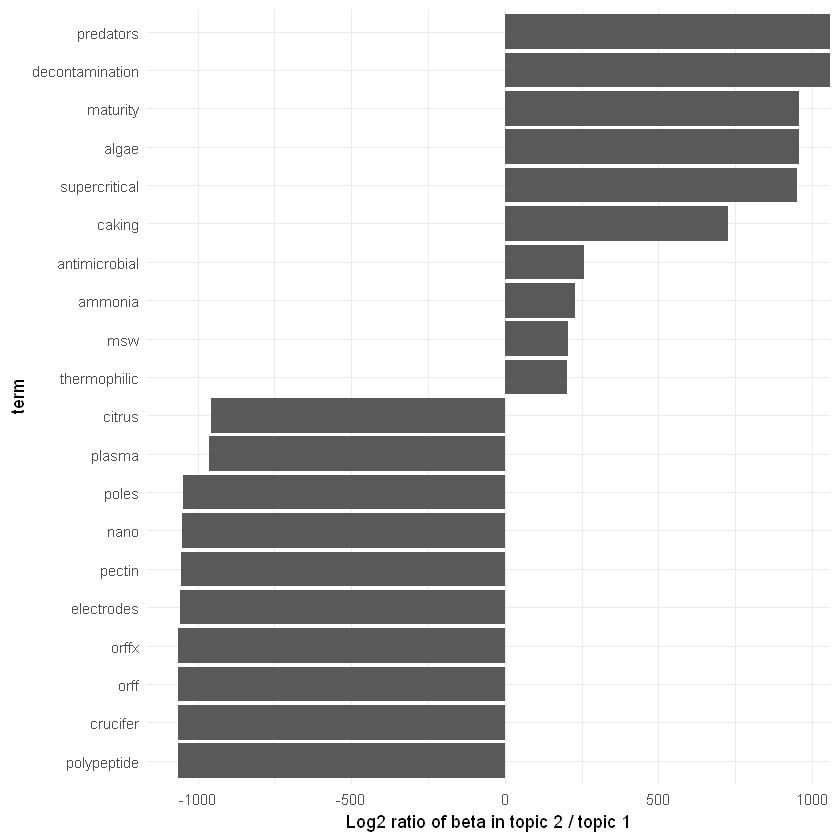

In [60]:
#beta spread topics 1 and 2 visualized
beta_spread %>%
  group_by(direction = log_ratio > 0) %>%
  top_n(10, abs(log_ratio)) %>%
  ungroup() %>%
  mutate(term = reorder(term, log_ratio)) %>%
  ggplot(aes(term, log_ratio)) +
  geom_col() +
  labs(y = "Log2 ratio of beta in topic 2 / topic 1") +
  coord_flip()